In [1]:
import os
import sys
from scgt import GeoTiff
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/')
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/ecoscape-connectivity/')
from EcoLinker.EcoLinker.restorationOptimizer import restorationOptimizer, defecitRestoration, noisyDefecitRestoration, utopianRestoration
from ecoscape_connectivity_local import repopulation, util
import matplotlib.pyplot as plt
# import ecoscape_connectivity
from scgt import GeoTiff, Tile
import numpy as np
import torch
import rasterio

In [2]:
DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH = os.path.join(DATA_PATH, "smol/hab_smol.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "smol/terrain.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "smol/restored_ter_smol.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "paper_repro/transmission_refined_1.csv")

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop.tif")
NOISY_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_noisy.tif")
UTOPIAN_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_utopian.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_after_restoration.tif")
FLOW_PATH = os.path.join(DATA_PATH, "smol/grad.tif")
NOISY_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_noisy.tif")
UTOPIAN_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_utopian.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_after_restoration.tif")
DEATH_PATH = os.path.join(DATA_PATH, "smol/death.tif")

# terrain changed tiffs
TERRAIN_CHANGED_DEFICIT = os.path.join(DATA_PATH, "smol/changed_terrain_defecit.tif")
TERRAIN_CHANGED_NOISY = os.path.join(DATA_PATH, "smol/changed_terrain_noisy.tif")
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol/changed_terrain_utopian.tif")
# changed connectivity
CONNECTIVITY_DIFF_DEFECIT = os.path.join(DATA_PATH, "smol/connectivity_diff_defecit.tif")
CONNECTIVITY_DIFF_NOISY = os.path.join(DATA_PATH, "smol/connectivity_diff_noisy.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol/connectivity_diff_utopian.tif")

defecitOptimizer = defecitRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50)
noisyOptimizer = noisyDefecitRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, NOISY_CONNECTIVITY_PATH, NOISY_FLOW_PATH, rand_divisor=1)
utopianOptimizer = utopianRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, UTOPIAN_CONNECTIVITY_PATH, UTOPIAN_FLOW_PATH, permiability=1.0)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


(1, 218, 312)


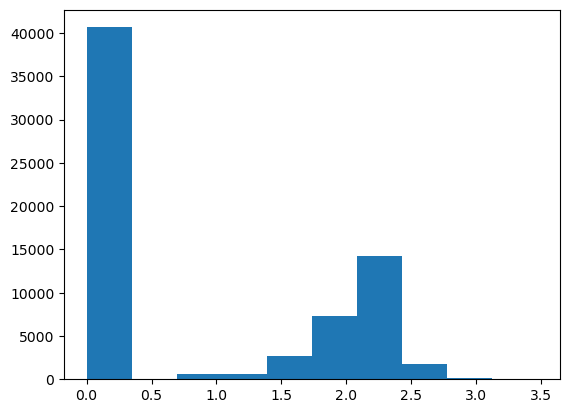

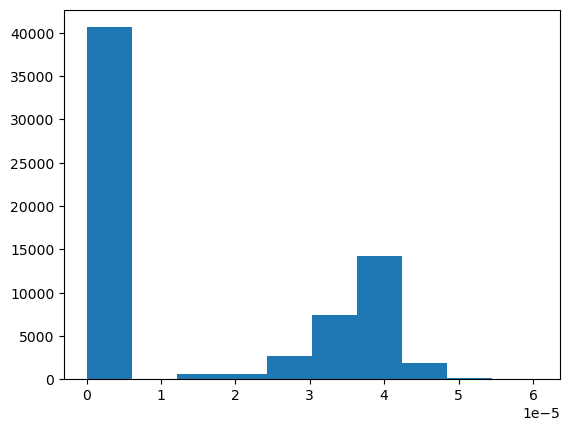

[0. 0. 0. ... 0. 0. 0.]
1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 1026
Permiability Restored: 4.990861313868612
Percent connectivity changed: 0.00031236803896502054%
Connectivity/permiability_restored: 205.57573842994793


In [87]:
from matplotlib import pyplot

changed_pixels = {}

def restore_pixels(defecitOptimizer, n=None, terrain_type=None, flow_fn=None, verbose=False):
    current_terr_tile = GeoTiff.from_file(defecitOptimizer.terrain_fn).get_all_as_tile()
    with GeoTiff.from_file(defecitOptimizer.restored_terr_fn) as restored_terr:
        restored_terr.set_tile(current_terr_tile)

    death_tif = defecitOptimizer.get_death_layer(defecitOptimizer.death_fn, flow_fn=flow_fn)
    death_mat = death_tif.get_all_as_tile().m
    i, rows, cols = death_mat.shape
    # cast death_mat to 1d to use numpy.random.choice with p for weights by values
    death_mat_probs = np.cbrt(death_mat.ravel())
    death_mat_probs = np.divide(death_mat_probs, np.sum(death_mat_probs))
    # sample indexes from range of probs, with no replacement and weighted by probs
    death_indices = np.random.choice(np.arange(death_mat_probs.size), size=n, replace=False, p=death_mat_probs)
    permiability_change = 0 
    for index in death_indices:
        x, y = index // cols, index % cols # col, row
        changed_pixels[(y,x)] = death_mat[0][x][y]
        permiability_change += defecitOptimizer.change_terrain(y, x, terrain_type, verbose=verbose)
    return permiability_change

# defecitOptimizer.run_connectivity()
permiability_restored = restore_pixels(defecitOptimizer, defecitOptimizer.pixels)
# permiability_restored = defecitOptimizer.restore()
defecitOptimizer.run_connectivity(restored=True)
print(f"Delta connectivity: {defecitOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {defecitOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {defecitOptimizer.get_delta_connectivity()/permiability_restored}")

{(245, 49): 8, (208, 104): 16, (192, 77): 12, (53, 91): 7, (41, 103): 6, (303, 160): 13, (236, 181): 9, (146, 77): 9, (21, 101): 15, (24, 51): 9, (283, 38): 12, (191, 186): 12, (282, 128): 15, (53, 94): 13, (150, 183): 9, (131, 70): 15, (289, 160): 5, (47, 73): 11, (182, 114): 13, (75, 142): 13, (287, 208): 6, (298, 31): 14, (116, 11): 11, (290, 19): 14, (114, 20): 6, (306, 103): 8, (298, 30): 6, (296, 143): 14, (140, 174): 14, (174, 187): 13, (133, 150): 8, (121, 27): 15, (186, 179): 11, (172, 106): 13, (28, 39): 15, (165, 171): 14, (198, 139): 6, (267, 113): 13, (291, 122): 12, (259, 2): 15, (45, 5): 14, (103, 22): 12, (141, 123): 11, (288, 11): 2, (268, 91): 9, (161, 90): 12, (308, 141): 4, (125, 177): 12, (54, 117): 13, (276, 189): 12}


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

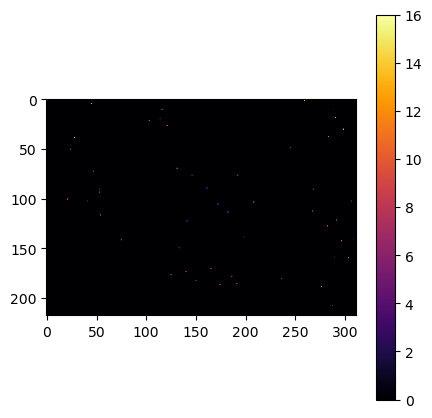

In [88]:
# paint changed terrain pixels
print(changed_pixels)
defecitOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_DEFICIT, changed_pixels=changed_pixels)
with GeoTiff.from_file(TERRAIN_CHANGED_DEFICIT) as terrain_changed:
    terrain_changed.draw_geotiff()

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

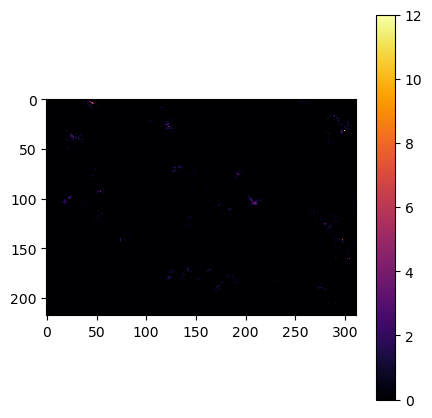

In [89]:
# view diff of before and after
defecitOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_DEFECIT)
with GeoTiff.from_file(CONNECTIVITY_DIFF_DEFECIT) as connectivity_changed:
    connectivity_changed.draw_geotiff()

In [24]:
noisyOptimizer.run_connectivity()
noisyOptimizer.run_noisy_connectivity()
permiability_restored = noisyOptimizer.restore()
noisyOptimizer.run_connectivity(restored=True)
print(f"Delta connectivity: {noisyOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {noisyOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {noisyOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 1356
Permiability Restored: 36.277781022350354
Percent connectivity changed: 0.0004128372912637114%
Connectivity/permiability_restored: 37.37825086833681


In [26]:
# paint changed terrain pixels
noisyOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_NOISY)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [27]:
# view diff of before and after
noisyOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_NOISY)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [28]:
# utopian restoration
utopianOptimizer.run_connectivity()
utopianOptimizer.run_utopian_connectivity()
permiability_restored = utopianOptimizer.restore()
utopianOptimizer.run_connectivity(restored=True)
print(f"Delta connectivity: {utopianOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {utopianOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {utopianOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


{(19, 4): 62, (235, 14): 60, (233, 23): 60, (228, 11): 59, (233, 13): 58, (230, 15): 58, (223, 13): 57, (230, 28): 57, (224, 12): 57, (226, 13): 57, (226, 14): 57, (119, 100): 57, (230, 16): 57, (226, 10): 57, (242, 164): 56, (230, 14): 56, (223, 10): 56, (182, 162): 56, (231, 12): 56, (245, 17): 56, (238, 13): 56, (229, 15): 56, (229, 14): 56, (122, 97): 56, (243, 159): 56, (121, 98): 56, (235, 28): 56, (195, 87): 56, (239, 23): 56, (283, 50): 56, (50, 97): 55, (209, 143): 55, (231, 17): 55, (156, 166): 55, (224, 11): 55, (223, 11): 55, (284, 51): 55, (238, 22): 55, (238, 24): 55, (227, 12): 55, (238, 23): 55, (10, 4): 55, (237, 23): 55, (225, 14): 54, (162, 162): 54, (48, 112): 54, (181, 161): 54, (175, 155): 54, (231, 15): 54, (242, 19): 54}


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 1118
Permiability Restored: 31.91635036510222
Percent connectivity changed: 0.0003403776486967768%
Connectivity/permiability_restored: 35.02906777281267


In [29]:
# paint changed terrain pixels
diff = utopianOptimizer.get_flow_diff()
highest_diff = utopianOptimizer.get_highest_diff_pixels(diff)
utopianOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, highest_diff)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [30]:
# view diff of before and after
utopianOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


## Now with more pixels restored...

In [70]:
DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH = os.path.join(DATA_PATH, "smol/hab_smol.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "smol/terrain.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "smol/restored_ter_smol.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "paper_repro/transmission_refined_1.csv")

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop.tif")
NOISY_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_noisy.tif")
UTOPIAN_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_utopian.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_after_restoration.tif")
FLOW_PATH = os.path.join(DATA_PATH, "smol/grad.tif")
NOISY_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_noisy.tif")
UTOPIAN_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_utopian.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_after_restoration.tif")
DEATH_PATH = os.path.join(DATA_PATH, "smol/death.tif")

# terrain changed tiffs
TERRAIN_CHANGED_DEFICIT = os.path.join(DATA_PATH, "smol/changed_terrain_defecit_250.tif")
TERRAIN_CHANGED_NOISY = os.path.join(DATA_PATH, "smol/changed_terrain_noisy_100.tif")
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol/changed_terrain_utopian_250.tif")
# changed connectivity
CONNECTIVITY_DIFF_DEFECIT = os.path.join(DATA_PATH, "smol/connectivity_diff_defecit_250.tif")
CONNECTIVITY_DIFF_NOISY = os.path.join(DATA_PATH, "smol/connectivity_diff_noisy_100.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol/connectivity_diff_utopian_250.tif")

defecitOptimizer = defecitRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 250)
noisyOptimizer = noisyDefecitRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 100, NOISY_CONNECTIVITY_PATH, NOISY_FLOW_PATH, rand_divisor=1)
utopianOptimizer = utopianRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 250, UTOPIAN_CONNECTIVITY_PATH, UTOPIAN_FLOW_PATH, permiability=1.0)

In [69]:
defecitOptimizer.run_connectivity()
permiability_restored = defecitOptimizer.restore()
defecitOptimizer.run_connectivity(restored=True)
print(f"Delta connectivity: {defecitOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {defecitOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {defecitOptimizer.get_delta_connectivity()/permiability_restored}")

# paint changed terrain pixels
defecitOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_DEFICIT)

# view diff of before and after
defecitOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_DEFECIT)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 13359
Permiability Restored: 135.31962044291953
Percent connectivity changed: 0.004067178004418821%
Connectivity/permiability_restored: 98.72182582447523


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [39]:
noisyOptimizer.run_connectivity()
noisyOptimizer.run_noisy_connectivity()
permiability_restored = noisyOptimizer.restore()
noisyOptimizer.run_connectivity(restored=True)
print(f"Delta connectivity: {noisyOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {noisyOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {noisyOptimizer.get_delta_connectivity()/permiability_restored}")

# paint changed terrain pixels
noisyOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_NOISY)

# view diff of before and after
noisyOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_NOISY)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

Delta connectivity: 2328
Permiability Restored: 72.68116788502192
Percent connectivity changed: 0.0007087649071253098%
Connectivity/permiability_restored: 32.03030534240703


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [71]:
# utopian restoration
utopianOptimizer.run_connectivity()
utopianOptimizer.run_utopian_connectivity()
permiability_restored = utopianOptimizer.restore()
utopianOptimizer.run_connectivity(restored=True)
print(f"Delta connectivity: {utopianOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {utopianOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {utopianOptimizer.get_delta_connectivity()/permiability_restored}")

# paint changed terrain pixels
diff = utopianOptimizer.get_flow_diff()
highest_diff = utopianOptimizer.get_highest_diff_pixels(diff)
utopianOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, highest_diff)

# view diff of before and after
utopianOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


{(19, 4): 62, (233, 23): 60, (235, 14): 60, (228, 11): 59, (233, 13): 58, (230, 15): 58, (226, 10): 57, (230, 28): 57, (119, 100): 57, (224, 12): 57, (226, 14): 57, (226, 13): 57, (223, 13): 57, (230, 16): 57, (245, 17): 56, (229, 15): 56, (122, 97): 56, (239, 23): 56, (121, 98): 56, (230, 14): 56, (229, 14): 56, (238, 13): 56, (242, 164): 56, (182, 162): 56, (231, 12): 56, (235, 28): 56, (223, 10): 56, (195, 87): 56, (243, 159): 56, (283, 50): 56, (231, 17): 55, (50, 97): 55, (156, 166): 55, (10, 4): 55, (284, 51): 55, (209, 143): 55, (223, 11): 55, (238, 24): 55, (224, 11): 55, (238, 22): 55, (227, 12): 55, (238, 23): 55, (237, 23): 55, (175, 155): 54, (222, 141): 54, (231, 15): 54, (227, 10): 54, (225, 10): 54, (224, 10): 54, (145, 168): 54, (242, 19): 54, (225, 14): 54, (234, 22): 54, (226, 11): 54, (224, 9): 54, (162, 162): 54, (48, 112): 54, (225, 11): 54, (225, 12): 54, (68, 48): 54, (261, 30): 54, (181, 161): 54, (152, 160): 54, (42, 17): 54, (227, 16): 54, (227, 11): 54, (227,

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 6387
Permiability Restored: 137.45369343274425
Percent connectivity changed: 0.0019445367103992069%
Connectivity/permiability_restored: 46.466557867542086


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


## Test corridor

In [64]:
# xys = [(235, 67), (234, 67), (236, 67), (235, 66), (235, 68), (234, 66), (236, 68), (235, 69), (229, 71)]
defecitOptimizer2 = defecitRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 250)

# reset restored terrain tif
current_terr_tile = GeoTiff.from_file(defecitOptimizer2.terrain_fn).get_all_as_tile()
with GeoTiff.from_file(defecitOptimizer2.restored_terr_fn) as restored_terr:
    restored_terr.set_tile(current_terr_tile)

xys = {}
for rows in range(45, 100, 5):
    for cols in range(238, 245, 2):
        xys[(cols, rows)] = 1

print(len(xys))

defecitOptimizer2.run_connectivity()
permiability_change = 0
for x, y in xys.keys():
    permiability_change += defecitOptimizer2.change_terrain(x, y)
defecitOptimizer2.run_connectivity(restored=True)
print(f"Delta connectivity: {defecitOptimizer2.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_change}")
print(f"Percent connectivity changed: {defecitOptimizer2.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {defecitOptimizer2.get_delta_connectivity()/permiability_change}")

44


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 77
Permiability Restored: 3.700000000000002
Percent connectivity changed: 2.344282553636119e-05%
Connectivity/permiability_restored: 20.8108108108108


In [61]:
# paint changed terrain pixels
defecitOptimizer2.paint_changed_terrain_geotiff(TERRAIN_CHANGED_DEFICIT, changed_pixels=xys)

# view diff of before and after
defecitOptimizer2.get_connectivity_difference_tif(CONNECTIVITY_DIFF_DEFECIT)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
